In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load your time series dataset
data = pd.read_csv('/kaggle/input/solarwind/solarwind.csv', index_col='datetime', parse_dates=['datetime'])

solar_features = ['global_horizontal_irradiance', 'direct_normal_irradiance', 'diffuse_horizontal_irradiance',
                  'solar_altitude_angle', 'solar_azimuth_angle', 'solar_incident_angle', 'horizon_elevation_angle',
                  'tracker_roll_angle', 'adjusted_ghi', 'poa_direct_irradiance', 'poa_diffuse_irradiance',
                  'poa_reflected_irradiance', 'shaded_direct_irradiance', 'shaded_diffuse_irradiance',
                  'shaded_reflected_irradiance', 'effective_direct_irradiance', 'effective_diffuse_irradiance',
                  'effective_reflected_irradiance', 'soiled_irradiance', 'total_irradiance', 'nameplate_power',
                  'avg_cell_temp', 'module_irradiance_derated_power', 'module_mpp_power', 'module_power',
                  'optimizer_input_power', 'optimizer_output_power', 'optimal_dc_power', 'optimal_dc_voltage',
                  'inverter_overpower_loss', 'inverter_underpower_loss', 'inverter_overvoltage_loss',
                  'inverter_undervoltage_loss', 'actual_dc_power', 'actual_dc_voltage', 'ac_power', 'grid_power']
wind_features = ['pressure', 'temperature_2m', 'wind_speed_10m', 'wind_speed_50m', 'wind_speed_150m',
                 'temperature_122m', 'roughness_length', 'dry_bulb_temperature', 'windspeed']
target_feature = 'power_output'


# Feature Engineering (create daylight feature and extract time-related features)
data['is_daylight'] = np.where(data['solar_incident_angle'] != 0, True, False)
data['hour'] = data.index.hour
data['day'] = data.index.dayofyear
# data['timestamp'] = data.index


In [41]:
# Selecting all features for feature engineering and importance calculations
input_features = ['is_daylight', 'hour', 'day'] + solar_features + wind_features
input_features.sort()
target_feature = 'power_output'

# Prepare input (X) and target (y)
X = data[input_features]
y = data[target_feature]

# Split data into training, validation, and prediction sets
X_train, X_temp, y_train, y_temp = train_test_split(data[input_features], data[target_feature], test_size=0.3, shuffle=False)
X_val, X_pred, y_val, y_pred = train_test_split(X_temp, y_temp, test_size=0.33, shuffle=False)

In [26]:
# X_train.info()

# print(X_train.sample(10))

# X_train.describe()

In [42]:
# Scaling and resampling for RF Regression for feature impotrance
# Prepare input (X) and target (y)
X = data[input_features]
y = data[target_feature]

# Resample data to hourly frequency
X_resampled = X.resample('H').mean()
y_resampled = y.resample('H').mean()

# Prepare input (X) and target (y)
X = X_resampled
y = y_resampled

# Split data into training, validation, and prediction sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_pred, y_val, y_pred = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False)

# Normalize the data
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_val)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Reshape y_train
y_test_scaled = scaler_y.fit_transform(y_val.values.reshape(-1, 1))  

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


                            Feature  Correlation
46                  wind_speed_150m     0.956976
45                   wind_speed_10m     0.955029
47                   wind_speed_50m     0.893813
13                       grid_power     0.149260
0                          ac_power     0.149260
1                   actual_dc_power     0.149020
22                 module_mpp_power     0.148812
25                 optimal_dc_power     0.148490
23                     module_power     0.148373
26               optimal_dc_voltage     0.141897
37                soiled_irradiance     0.141211
43                 total_irradiance     0.141209
24                  nameplate_power     0.141209
21  module_irradiance_derated_power     0.140653
2                 actual_dc_voltage     0.140257
10      effective_direct_irradiance     0.129741
30            poa_direct_irradiance     0.128789
35         shaded_direct_irradiance     0.128558
38             solar_altitude_angle     0.114281
48                  

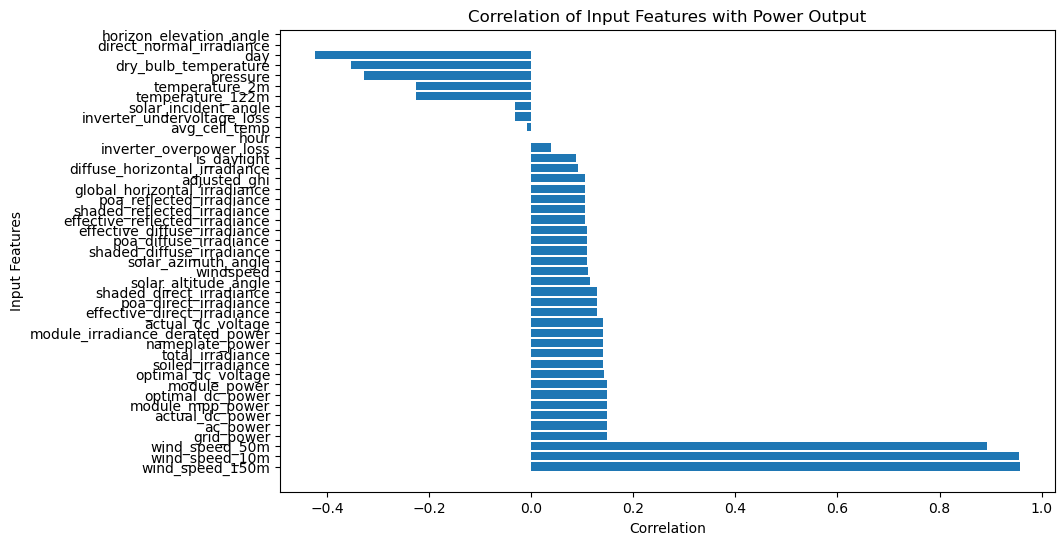

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# input_features = data.columns
# Calculate correlation
correlation = pd.DataFrame({'Feature': input_features})
correlation['Correlation'] = [np.corrcoef(X_train_scaled[:, i], y_train_scaled.flatten())[0, 1] for i in range(X_train_scaled.shape[1])]
correlation = correlation.sort_values(by='Correlation', ascending=False)

print(correlation)

# Plot correlation values
plt.figure(figsize=(10, 6))
plt.barh(correlation['Feature'], correlation['Correlation'])
plt.xlabel("Correlation")
plt.ylabel("Input Features")
plt.title("Correlation of Input Features with Power Output")
plt.show()


Feature Importance Ranking:
1. wind_speed_150m: 0.9998851312109501
2. wind_speed_10m: 5.7559287155522135e-05
3. pressure: 1.2458289556529478e-05
4. day: 6.896467156217322e-06
5. dry_bulb_temperature: 6.621096030205217e-06
6. wind_speed_50m: 4.971859811841794e-06
7. actual_dc_voltage: 4.530643397715649e-06
8. optimal_dc_voltage: 4.096206540421924e-06
9. temperature_122m: 3.0558449200811605e-06
10. solar_altitude_angle: 2.899289422260426e-06
11. temperature_2m: 2.8868071702917745e-06
12. effective_direct_irradiance: 2.0160436350010057e-06
13. module_irradiance_derated_power: 8.468942323379432e-07
14. soiled_irradiance: 7.748268776007923e-07
15. total_irradiance: 7.069323642609599e-07
16. actual_dc_power: 6.975084167682286e-07
17. module_power: 6.95012883433096e-07
18. nameplate_power: 6.837199210558874e-07
19. module_mpp_power: 6.436730455228959e-07
20. grid_power: 6.257036896135515e-07
21. ac_power: 6.059894205804284e-07
22. optimal_dc_power: 5.966934026592315e-07


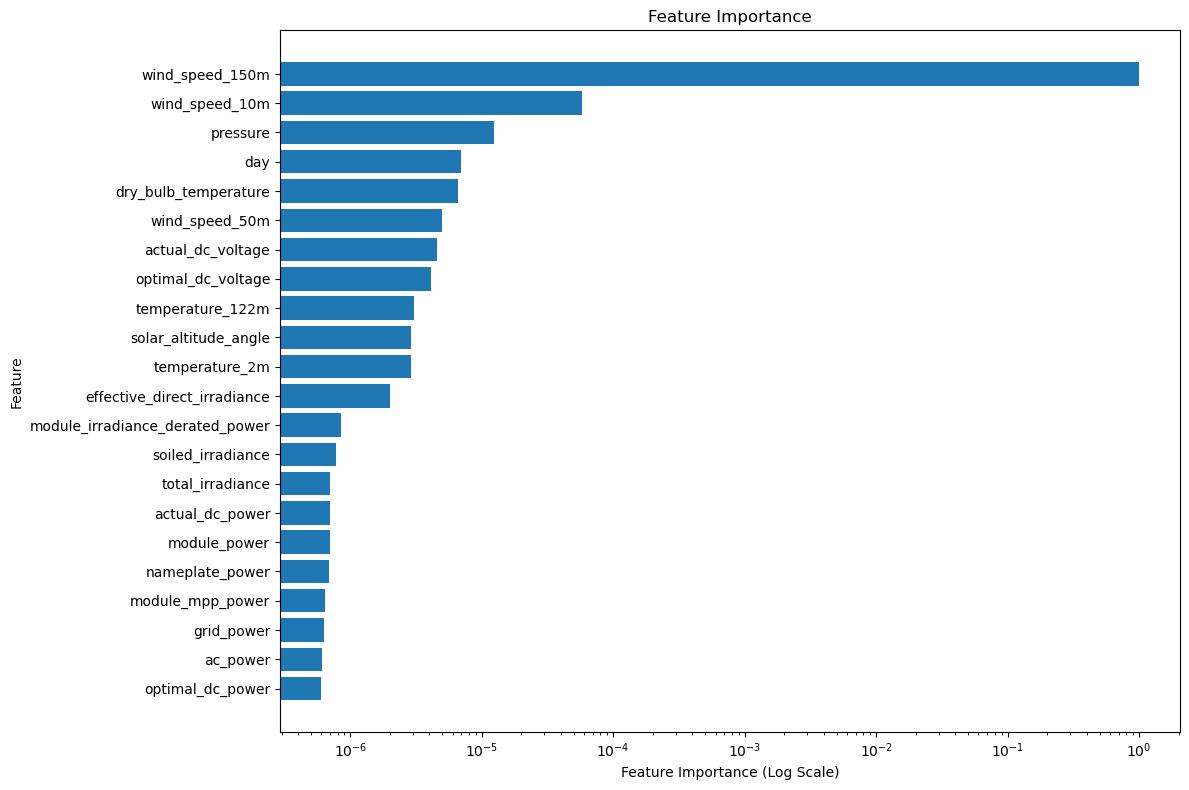

In [300]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Get the feature names in the original order
feature_names = input_features

# Print the feature importance ranking
print("Feature Importance Ranking:")
for i, idx in enumerate(sorted_indices):
    print(f"{i+1}. {feature_names[idx]}: {feature_importances[idx]}")

import matplotlib.pyplot as plt

# Plot the feature importances on a log scale
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Feature Importance (Log Scale)')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.xscale('log')  # Use log scale for x-axis
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.tight_layout()
plt.show()

wind_speed_150m                    0.957553
wind_speed_10m                     0.956770
wind_speed_50m                     0.889524
pressure                           0.269868
dry_bulb_temperature               0.264689
day                                0.257511
grid_power                         0.166979
ac_power                           0.166979
actual_dc_power                    0.166772
optimal_dc_voltage                 0.166539
module_mpp_power                   0.166315
optimal_dc_power                   0.166058
module_power                       0.165922
soiled_irradiance                  0.159678
total_irradiance                   0.159675
nameplate_power                    0.159675
module_irradiance_derated_power    0.158844
actual_dc_voltage                  0.156539
solar_altitude_angle               0.140691
effective_direct_irradiance        0.139779
shaded_diffuse_irradiance          0.139448
poa_diffuse_irradiance             0.139448
effective_diffuse_irradiance    

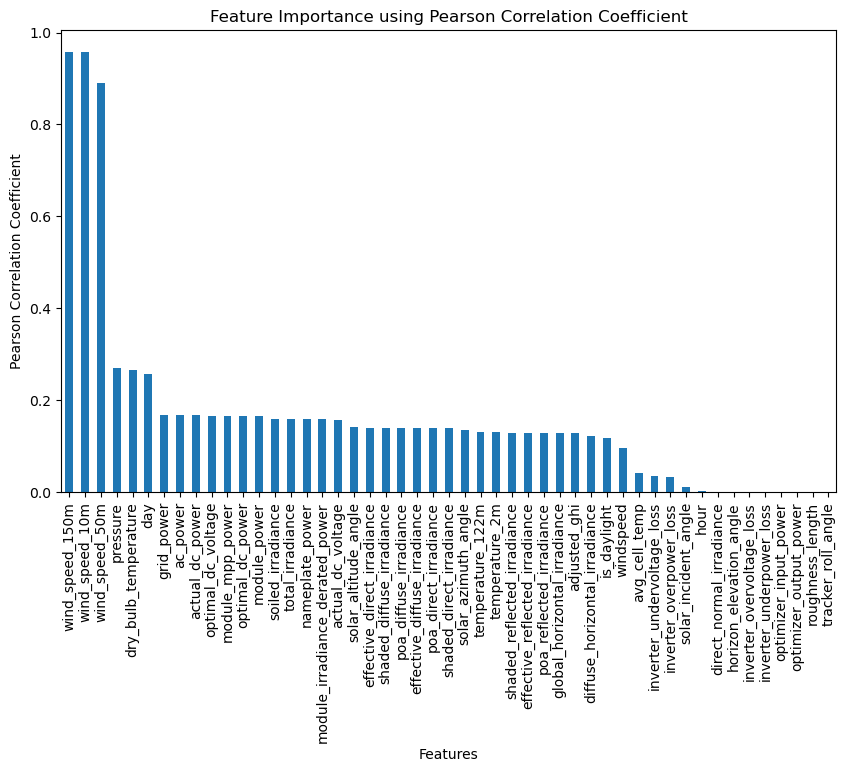

In [28]:

# Calculate Pearson correlation coefficients
correlation_coeffs = data[input_features + [target_feature]].corr()[target_feature]

# Exclude the target variable itself
correlation_coeffs = correlation_coeffs.drop(target_feature)

# Sort the coefficients in descending order of absolute values
sorted_coeffs = correlation_coeffs.abs().sort_values(ascending=False)

print(sorted_coeffs)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sorted_coeffs.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Feature Importance using Pearson Correlation Coefficient')
plt.show()

wind_speed_150m, 3963468.4785453747
wind_speed_10m, 3784825.8538630554
wind_speed_50m, 1446884.8240955397
day, 80010.45782808383
dry_bulb_temperature, 51874.09345520745
pressure, 43891.27956563265
temperature_2m, 19363.432227730744
temperature_122m, 19363.432227628105
grid_power, 8487.143990128034
ac_power, 8487.14385038214
actual_dc_power, 8459.395795499004
module_mpp_power, 8434.368045680569
optimal_dc_power, 8397.674738577334
module_power, 8383.977671716942
soiled_irradiance, 7584.270680834091
total_irradiance, 7584.037236792784
nameplate_power, 7584.035192931694
module_irradiance_derated_power, 7522.61000389108
optimal_dc_voltage, 7485.006045918214
actual_dc_voltage, 7290.99354560537
effective_direct_irradiance, 6325.614071510616
poa_direct_irradiance, 6234.817011493335
shaded_direct_irradiance, 6212.399489877304
solar_altitude_angle, 5011.371886707063
windspeed, 4551.017778632215
shaded_diffuse_irradiance, 4514.92082776642
poa_diffuse_irradiance, 4514.9208234153475
effective_diffu

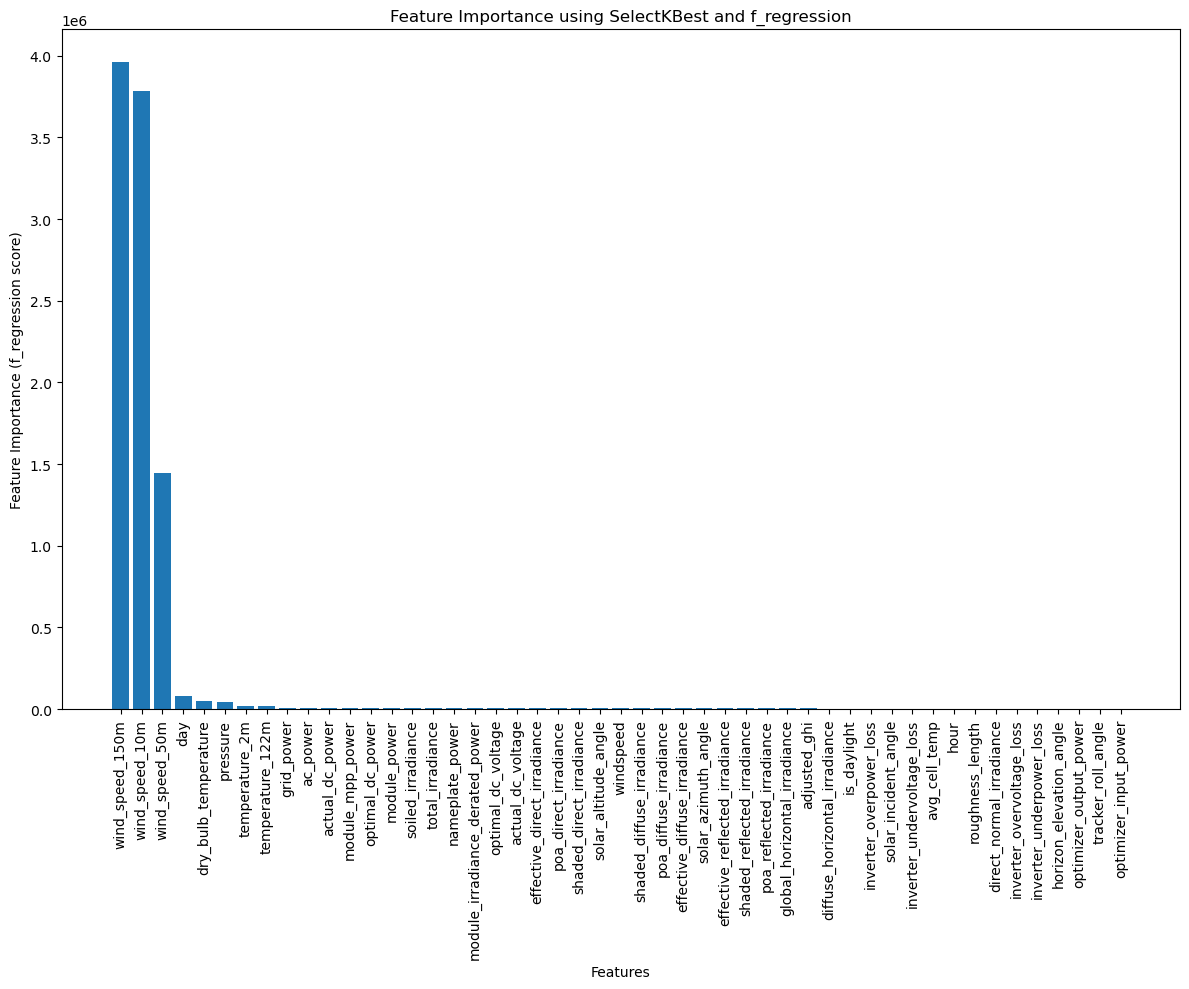

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Apply feature selection using SelectKBest and f_regression
fs = SelectKBest(score_func=f_regression, k=len(input_features))
X_selected = fs.fit_transform(X_train, y_train)

selected_feature_names = X_train.columns[fs.get_support()]  # Get the names of selected features
feature_importance_scores = fs.scores_[fs.get_support()]  # Get the importance scores of selected features

# Sort the selected feature names based on importance scores
sorted_indices = np.argsort(feature_importance_scores)[::-1]
selected_feature_names_sorted = selected_feature_names[sorted_indices]
sorted_importances = feature_importance_scores[sorted_indices]

# Print the selected feature names and their importance scores
for feature, score in zip(selected_feature_names_sorted, sorted_importances):
    print(f"{feature}, {score}")

        
plt.figure(figsize=(12, 10))
plt.bar(selected_feature_names_sorted, sorted_importances)
plt.xlabel('Features')
plt.ylabel('Feature Importance (f_regression score)')
plt.title('Feature Importance using SelectKBest and f_regression')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from keras.losses import MeanSquaredError, MeanAbsoluteError, Huber
from keras.metrics import CosineSimilarity

# Load and preprocess data
data = pd.read_csv('/kaggle/input/solarwind/solarwind.csv', index_col='datetime', parse_dates=['datetime'])

# Resample data to 10 minutes mean aggregates
data_resampled = data.resample('1H').mean()

# Feature Engineering (create daylight feature and extract time-related features)
data_resampled['is_daylight'] = np.where(data_resampled['solar_incident_angle'] != 0, 1, 0)
data_resampled['hour'] = data_resampled.index.hour
data_resampled['day'] = data_resampled.index.dayofyear

# Define input features and target feature
input_features = ['wind_speed_150m', 'wind_speed_10m', 'wind_speed_50m', 'day', 'dry_bulb_temperature', 'pressure', 'temperature_122m', 'temperature_2m', 'grid_power', 'ac_power', 'actual_dc_power', 'module_mpp_power', 'optimal_dc_power', 'module_power', 'optimal_dc_voltage', 'soiled_irradiance', 'total_irradiance', 'nameplate_power', 'module_irradiance_derated_power', 'actual_dc_voltage']
target_feature = 'power_output'

# Load input features and target feature
X = data_resampled[input_features]
y = data_resampled[target_feature]

# Normalize the data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=False)

# Model parameters
past = 240
future = 24
step = 1
sequence_length = int(past / step)
learning_rate = 0.01
epochs = 100
batch_size = 4
output_sequence_length = int(future / step)

# Create time series datasets
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


In [51]:
print("data_resampled:",data_resampled.shape)

print("X_train:",X_train.shape)

print("y_train:",y_train.shape)

print("X_val:",X_val.shape)

print("y_val:",y_val.shape)
assert(int(X_val.shape[0] + X_train.shape[0] == data_resampled.shape[0]))
assert(int(y_val.shape[0] + y_train.shape[0] == data_resampled.shape[0]))

 
# Display shapes of inputs and targets in a batch
for batch in dataset_train.take(10):
    inputs, targets = batch
    print("Input shape:", inputs.numpy().shape)
    print("Target shape:", targets.numpy().shape)
    print(targets)
    

data_resampled: (8760, 51)
X_train: (6132, 20)
y_train: (6132, 1)
X_val: (2628, 20)
y_val: (2628, 1)
Input shape: (4, 240, 20)
Target shape: (4, 1)
tf.Tensor(
[[-0.78746171]
 [-0.8007675 ]
 [-0.81130328]
 [-0.83606361]], shape=(4, 1), dtype=float64)
Input shape: (4, 240, 20)
Target shape: (4, 1)
tf.Tensor(
[[-0.86550863]
 [-0.87623534]
 [-0.87467354]
 [-0.86031283]], shape=(4, 1), dtype=float64)
Input shape: (4, 240, 20)
Target shape: (4, 1)
tf.Tensor(
[[-0.81226774]
 [-0.72737013]
 [-0.65947299]
 [-0.62265354]], shape=(4, 1), dtype=float64)
Input shape: (4, 240, 20)
Target shape: (4, 1)
tf.Tensor(
[[-0.62301789]
 [-0.71534699]
 [-0.77404634]
 [-0.70014475]], shape=(4, 1), dtype=float64)
Input shape: (4, 240, 20)
Target shape: (4, 1)
tf.Tensor(
[[-0.61113795]
 [-0.56390967]
 [-0.52891461]
 [-0.47071868]], shape=(4, 1), dtype=float64)
Input shape: (4, 240, 20)
Target shape: (4, 1)
tf.Tensor(
[[-0.40575089]
 [-0.35773529]
 [-0.3499891 ]
 [-0.40599096]], shape=(4, 1), dtype=float64)
Input

In [52]:
from keras.layers import Input
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam
from keras.losses import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, Huber
from keras.metrics import CosineSimilarity
from keras.callbacks import EarlyStopping

# Build the model
model = keras.Sequential([
    keras.layers.Input(shape=(sequence_length, len(input_features))),
    keras.layers.LSTM(units=128),
    keras.layers.Dense(output_sequence_length)
])

# Compile the model
optimizer = RMSprop (learning_rate=learning_rate)
loss_function = [Huber(),MeanAbsoluteError()]
metrics = [Huber(), CosineSimilarity(), MeanAbsoluteError(), MeanSquaredError(), MeanAbsolutePercentageError()]

model.compile(optimizer=optimizer, loss=loss_function, 
              metrics=metrics)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

# Checkpoint callback
path_checkpoint = "/tmp/model_checkpoint.h5"

checkpoint = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

model.summary()

# Train the model
history = model.fit(dataset_train, epochs=epochs, validation_data=dataset_val, batch_size=batch_size, callbacks=[early_stopping, checkpoint])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               76288     
                                                                 
 dense_8 (Dense)             (None, 24)                3096      
                                                                 
Total params: 79,384
Trainable params: 79,384
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1474/1474 [==============================] - ETA: 0s - loss: 0.1611 - huber_loss: 0.1611 - cosine_similarity: 3.4565 - mean_absolute_error: 0.4025 - mean_squared_error: 0.3556 - mean_absolute_percentage_error: 252.9758
Epoch 1: val_loss improved from inf to 0.28909, saving model to /tmp/model_checkpoint.h5
1474/1474 [==============================] - 239s 161ms/step - loss: 0.1611 - huber_loss: 0.1611 - cosine_similarity: 3.4565 -

598/598 [==============================] - 18s 30ms/step


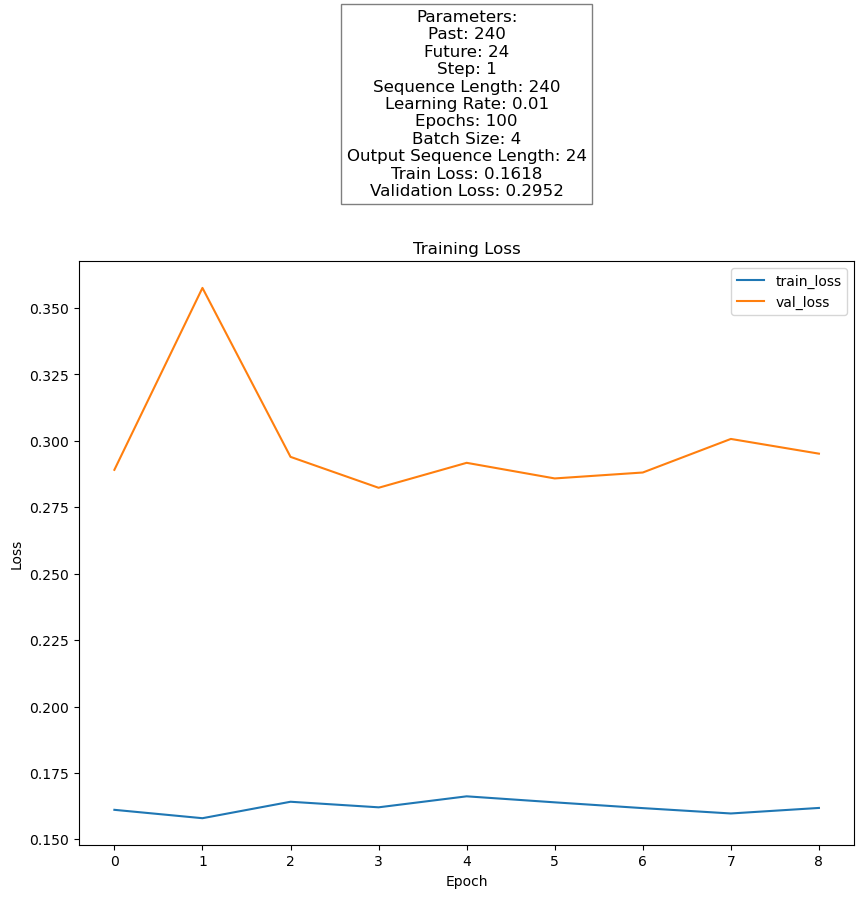

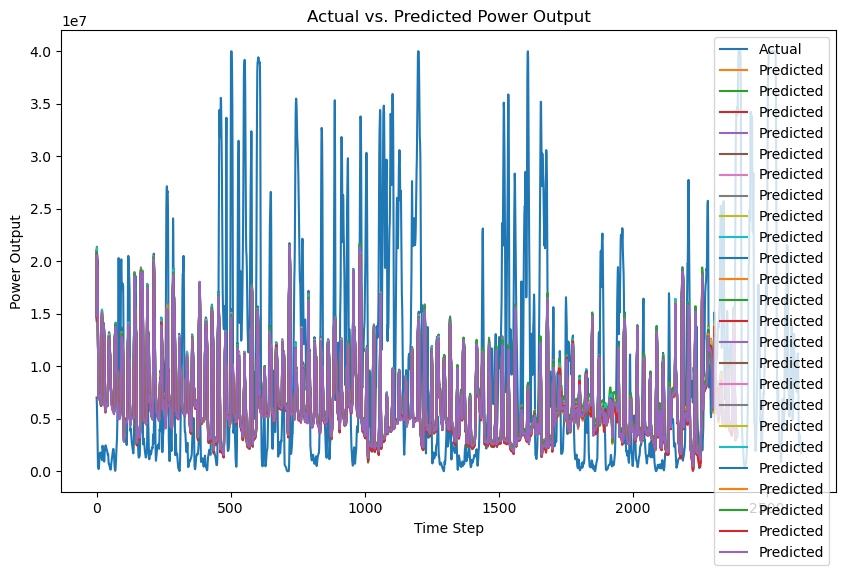

In [53]:
import matplotlib.pyplot as plt

# Generate parameter description
param_description = f"Past: {past}\nFuture: {future}\nStep: {step}\nSequence Length: {sequence_length}\nLearning Rate: {learning_rate}\nEpochs: {epochs}\nBatch Size: {batch_size}\nOutput Sequence Length: {output_sequence_length}"


y_val_pred = model.predict(dataset_val)
y_val_pred_actual = scaler_y.inverse_transform(y_val_pred)
y_val_actual = scaler_y.inverse_transform(y_val)


# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [0.1, 1]})

# Add annotation with parameter values
annotation_text = f"Parameters:\n{param_description}\nTrain Loss: {history.history['loss'][-1]:.4f}\nValidation Loss: {history.history['val_loss'][-1]:.4f}"
annotation = axes[0].annotate(annotation_text, (0.5, 0.5), ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
axes[0].axis('off')  # Hide axis for annotation subplot

# Add vertical space between annotation and plots
plt.subplots_adjust(hspace=0.4)

# Plot training history
axes[1].plot(history.history['loss'], label='train_loss')
axes[1].plot(history.history['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_title('Training Loss')

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_val_actual, label="Actual")
plt.plot(y_val_pred_actual, label="Predicted")
plt.xlabel("Time Step")
plt.ylabel("Power Output")
plt.title("Actual vs. Predicted Power Output")
plt.legend()

# Show the plots
plt.show()


In [55]:
for batch in dataset_val.take(2):
    inputs, targets = batch
    y_val_pred = model.predict(inputs)
    y_val_pred_actual = scaler_y.inverse_transform(y_val_pred)
    y_val_actual = scaler_y.inverse_transform(targets)

    # Print sample predictions and actual values
    sample_indices = np.random.choice(len(y_val_pred_actual), size=5, replace=True)
    print("Sample Predictions vs Actual Values:")
    for i in sample_indices:
        print(f"Sample {i+1} - Predicted: {y_val_pred_actual[i][0]:.2f}, Actual: {y_val_actual[i][0]:.2f}")

1/1 [==============================] - 0s 48ms/step
Sample Predictions vs Actual Values:
Sample 2 - Predicted: 20715514.00, Actual: 6333763.72
Sample 3 - Predicted: 19863794.00, Actual: 5088442.91
Sample 4 - Predicted: 19809306.00, Actual: 3608303.57
Sample 3 - Predicted: 19863794.00, Actual: 5088442.91
Sample 3 - Predicted: 19863794.00, Actual: 5088442.91
1/1 [==============================] - 0s 47ms/step
Sample Predictions vs Actual Values:
Sample 4 - Predicted: 7035280.00, Actual: 215435.07
Sample 2 - Predicted: 12427420.00, Actual: 541468.64
Sample 2 - Predicted: 12427420.00, Actual: 541468.64
Sample 1 - Predicted: 18428236.00, Actual: 1701571.56
Sample 4 - Predicted: 7035280.00, Actual: 215435.07


In [71]:
# CLear workingDir
import shutil
shutil.rmtree("/kaggle/working/*")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/*'